# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==2.0.0-alpha0**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])
    print(workingdir)
    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook/TF_2.0
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle

In [3]:
tf.__version__

'2.0.0-alpha0'

### Import our utils functions

In [4]:
import src.utils.mnist_utils as mnist_utils

Current Working direcotory:	/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [5]:
import importlib
importlib.reload(mnist_utils);# to reload the function and mask the output

### Set plots style

In [6]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [7]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [8]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

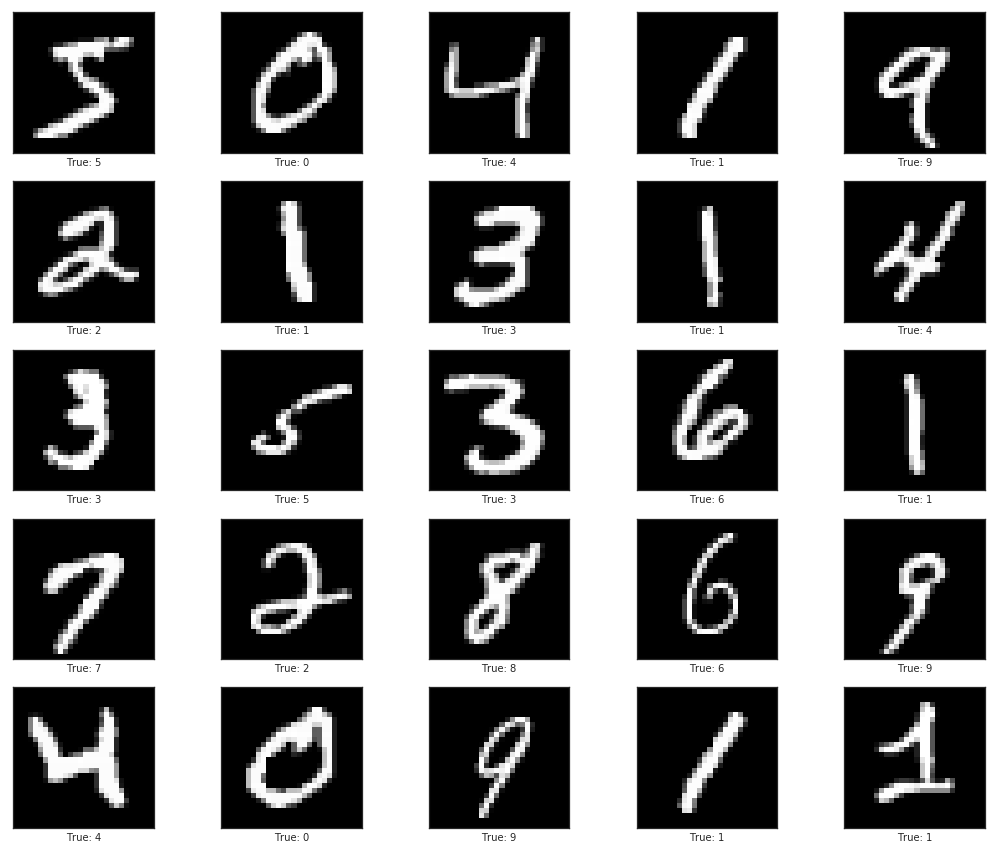

In [9]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Data exploration

In [10]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [11]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [12]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [13]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)

(255, 0, 255, 0)

## Normalize and reorganize the data

In [14]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [15]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [16]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [17]:
x_train.shape

(60000, 784)

In [18]:
x_test.shape

(10000, 784)

## Reshape the labels

In [19]:
y_train.shape

(60000,)

In [20]:
y_test.shape

(10000,)

In [21]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [22]:
num_classes = len(np.unique(y_train))
num_classes

10

In [23]:
y_train_ = np.zeros((len(y_train), num_classes))
y_test_ = np.zeros((len(y_test), num_classes))

In [24]:
y_train_[np.arange(len(y_train)), y_train] = 1
y_test_[np.arange(len(y_test)), y_test] = 1

In [25]:
y_train=y_train_
y_test=y_test_

In [26]:
y_train.shape

(60000, 10)

In [27]:
y_test.shape

(10000, 10)

In [28]:
dim_input=x_train.shape[1]
dim_input

784

## Defined some hyperparameters

In [29]:
# print info every n_print
n_print = 1

# hidden layer 1
n1=300

## Defined our model

In [88]:
# x [60000, 784]
# y [60000, 10]

# 1 layer n1 with 200 neurones
# n1 = 300

#  . . . . . .    input data (ffattened pixels)      x [batch    ,   dim_input]
#   \x/\x/x/      -- fully connected layer (relu)    W1[dim_input,          n1]      B1[n1         ]
#    . . .                                           Y1[batch    ,          n1]
#     \x/         -- fully connected layer (softmax) W2[n1       , num_classes]      B2[num_classes]
#      .                                             Y2[batch    , num_classes]

# reset graph before starting
tf.compat.v1.reset_default_graph()

# tensor (placeholder) for the learning rate: learning_rate -> not needed with Eager execution

# tensor (placeholder) for the momentum: momentum -> not needed with Eager execution

# tensor (placeholder) for the input data [60000, 784]: x -> not needed with Eager execution

# tensor (placeholder) for the output data [60000, 10]: y -> not needed with Eager execution

# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random.normal([dim_input, n1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([n1]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random.normal([n1, num_classes], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([num_classes]), name='b2') 

In [137]:
# now let's define the cost function which we are going to train the model on
# cross entropy defined manually -> need to be a function in Eager mode
# -sum(y * log(y_) + (1-y) * log(1-y_))
# need to be a function -> Eager execution
@tf.function
def model(x,y): 
    
    # calculate the output of the hidden layer
    print(x)
    Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    # last layer
    Ylogits= tf.matmul(Y1, W2) + b2

    # output layer
    y_ = tf.nn.softmax(Ylogits)
    
    return y_


In [138]:
@tf.function
def loss(y, y_):
    y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999) # if value are below 1e-10 return 1e-10 same of 0.9999999
    cross_entropy = tf.reduce_sum(input_tensor=y * tf.math.log(y_clipped)+ (1 - y) * tf.math.log(1 - y_clipped), axis=1)
    return -tf.reduce_mean(input_tensor=cross_entropy)

In [139]:
# define an accuracy assessment operation
# need to be a function -> Eager execution
def acc(y_, y):
    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy.numpy()

In [140]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
    train_loss(loss)
    train_accuracy(label, predictions)

In [141]:
@tf.function
def test_step(image, label):
    predictions = model(image)
    t_loss = loss_object(label, predictions)
    
    test_loss(t_loss)
    test_accuracy(label, predictions)

In [155]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, test_obs, test_labels, debug = False):
    cost_history_train = np.empty(shape=[0], dtype = float)
    cost_history_test = np.empty(shape=[0], dtype = float)
    
    # add an optimiser
    optimizer = tf.keras.optimizers.SGD(lr=learning_r)
    
    for epoch in range(training_epochs+1):
        print('epoch', epoch)
        for image, label in zip(train_obs, train_labels):
            print('step 1')
            
            # watch the gradient flow 
            with tf.GradientTape() as tape:
                print('step 2')
                # forward pass
                y_=model(train_obs, train_labels)
                print('step 3')
                # calcuate the loss
                print(train_labels.dtype)
                print(y_)
                loss_train = loss(train_labels, y_)
                print('step 4')
                # evalute the gradient with the respect to the paramters
                dW1, db1, dW2, db2 = tape.gradient(loss_train, [W1, b1, W2, b2])
                print('step 4')
            # update the paramters using Gradient Descent  
            W1.assign_sub(dW1 * learning_r)
            b1.assign_sub(db1* learning_r)
            W2.assign_sub(dW2 * learning_r)
            b2.assign_sub(db2* learning_r)
            print('step 5')
            
        cost_history_train = np.append(cost_history_train, loss_train.numpy())
            
        #if (epoch % n_print == 0) & debug:
        print("Reached epoch", epoch, "cost J =", str.format('{0:.6f}', loss_train))
        
            #    acc_train=acc(y_train_.numpy(), train_labels)
            #    acc_test=acc(y_test_.numpy(), test_labels)      

            #    print(" accurary on the training set", str.format('{0:.2f}', acc_train))
            #    print(" accurary on the testing set", str.format('{0:.2f}', acc_test))
    

    # to add for Eager optimisation
    #grad=tfe.implicit_gradients(cost)

    #for epoch in range(training_epochs+1):
        
        #train_step(image, label)
        
        #optimiser.apply_gradients(grad(train_obs, train_labels))
        
        #cost_train, y_train_ = cost(train_obs, train_labels)
        #cost_history_train = np.append(cost_history_train, cost_train.numpy())
            
        #cost_test, y_test_ = cost(test_obs, test_labels)
        #cost_history_test = np.append(cost_history_test, cost_test.numpy())
        
        #if (epoch % n_print == 0) & debug:
        #    print("Reached epoch", epoch, "cost J =", str.format('{0:.6f}', cost_train))
        
        #    acc_train=acc(y_train_.numpy(), train_labels)
        #    acc_test=acc(y_test_.numpy(), test_labels)      

        #    print(" accurary on the training set", str.format('{0:.2f}', acc_train))
        #    print(" accurary on the testing set", str.format('{0:.2f}', acc_test))
            
    #print ("Accuracy on training data:", acc(y_train_.numpy(), y_train))
    #print ("Accuracy on testing data:",  acc(y_test_.numpy(), y_test))
    
    return cost_history_train, cost_history_test

In [156]:
# add an optimiser
#optimiser = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# finally setup the initialisation operator
#init= tf.compat.v1.global_variables_initializer()

In [157]:
cost_history_train, cost_history_test = run_logistic_model(learning_r = 0.2, 
                                                           training_epochs = 50,
                                                           train_obs = x_train, 
                                                           train_labels = y_train, 
                                                           test_obs = x_test,
                                                           test_labels = y_test, 
                                                           debug = True)

epoch 0
step 1
step 2
step 3
float64
tf.Tensor(
[[5.0367083e-02 2.3561215e-03 1.2359774e-02 ... 1.8486822e-02
  4.3933842e-02 1.3079669e-02]
 [9.6967053e-01 8.8626293e-06 2.1304337e-04 ... 2.3476870e-04
  3.6211431e-04 1.9014742e-04]
 [7.0349500e-03 8.5003693e-03 3.5129901e-02 ... 3.1957801e-02
  1.6898612e-02 2.0580308e-01]
 ...
 [4.9190377e-03 1.2958406e-03 1.5664268e-04 ... 1.0944692e-02
  5.6254648e-02 7.0850901e-02]
 [1.2513858e-01 1.7044094e-03 2.2296753e-02 ... 4.9041933e-03
  2.8170941e-03 1.4805929e-02]
 [6.2823214e-02 1.0338941e-02 3.8929064e-02 ... 2.9873844e-02
  3.5241550e-01 1.8263753e-01]], shape=(60000, 10), dtype=float32)


TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.

In [31]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, test_obs, test_labels, debug = False):
    sess = tf.compat.v1.Session()
    sess.run(init)

    cost_history_train = np.empty(shape=[0], dtype = float)
    cost_history_test = np.empty(shape=[0], dtype = float)

    for epoch in range(training_epochs+1):

        sess.run(optimiser, feed_dict = {x: train_obs, y: train_labels, learning_rate: learning_r})

        cost_train = sess.run(cost, feed_dict={x: train_obs, y: train_labels, learning_rate: learning_r})
        cost_history_train = np.append(cost_history_train, cost_train)

        cost_test = sess.run(cost, feed_dict={x: test_obs, y: test_labels, learning_rate: learning_r})
        cost_history_test = np.append(cost_history_test, cost_test)


        if (epoch % n_print == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_train))

            acc_train = sess.run(accuracy, feed_dict={x: train_obs, y: train_labels})
            acc_test = sess.run(accuracy, feed_dict={x: test_obs, y: test_labels})
            print(" accurary on the training set", str.format('{0:.2f}', acc_train))
            print(" accurary on the testing set", str.format('{0:.2f}', acc_test))

    return sess, cost_history_train, cost_history_test

In [32]:
sess, cost_history_train, cost_history_test = run_logistic_model(learning_r = 0.2,
                                                                 training_epochs = 50,
                                                                 train_obs = x_train,
                                                                 train_labels = y_train,
                                                                 test_obs = x_test,
                                                                 test_labels = y_test,
                                                                 debug = True)

Reached epoch 0 cost J = 4.578429
 accurary on the training set 0.14
 accurary on the testing set 0.14
Reached epoch 1 cost J = 4.751613
 accurary on the training set 0.12
 accurary on the testing set 0.12
Reached epoch 2 cost J = 4.343376
 accurary on the training set 0.16
 accurary on the testing set 0.16
Reached epoch 3 cost J = 4.232302
 accurary on the training set 0.15
 accurary on the testing set 0.16
Reached epoch 4 cost J = 3.678338
 accurary on the training set 0.27
 accurary on the testing set 0.27
Reached epoch 5 cost J = 3.130323
 accurary on the training set 0.23
 accurary on the testing set 0.24
Reached epoch 6 cost J = 2.928202
 accurary on the training set 0.34
 accurary on the testing set 0.35
Reached epoch 7 cost J = 2.758579
 accurary on the training set 0.50
 accurary on the testing set 0.50
Reached epoch 8 cost J = 2.607491
 accurary on the training set 0.46
 accurary on the testing set 0.48
Reached epoch 9 cost J = 2.537961
 accurary on the training set 0.64
 acc

In [33]:
print ("Accuracy on training data:", accuracy.eval(feed_dict={x: x_train, y: y_train}, session = sess))
print ("Accuracy on testing data:", accuracy.eval(feed_dict={x: x_test, y: y_test}, session = sess))


Accuracy on training data: 0.8513167
Accuracy on testing data: 0.8589


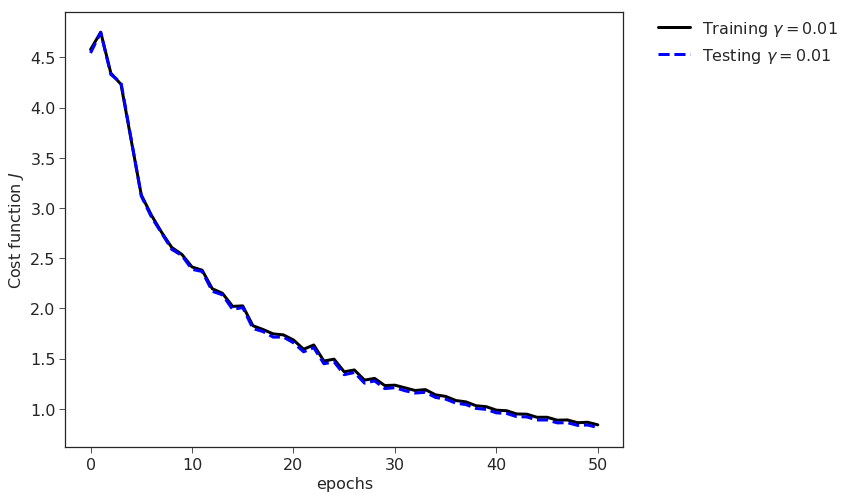

In [34]:
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history_train, ls='-', color = 'black', lw = 3, label = r'Training $\gamma = 0.01$')
ax.plot(cost_history_test, ls='--', color = 'blue', lw = 3, label = r'Testing $\gamma = 0.01$')

ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$', fontsize = 16)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)
plt.tick_params(labelsize=16);